In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
import sys
import torch
from torch_geometric.data import Data
from torch_geometric.data import Dataset, DataLoader
from random import sample 
import os
import networkx as nx

sys.path.insert(0, 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk')
print(sys.path)
from pyCaMOtk.create_mesh_hsphere import mesh_hsphere
from pyCaMOtk.create_mesh_hcube import mesh_hcube 
from pyCaMOtk.setup_linelptc_sclr_base_handcode import setup_linelptc_sclr_base_handcode
from pyCaMOtk.create_dbc_strct import create_dbc_strct
from pyCaMOtk.create_femsp_cg import create_femsp_cg
from pyCaMOtk.solve_fem import solve_fem
from pyCaMOtk.visualize_fem import visualize_fem
from pyCaMOtk.lfcnsp import LocalFunctionSpace

sys.path.insert(0, 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source')
from FEM_ForwardModel import analyticalPossion, analyticalConeInterpolation
from GCNNModel import e2vcg2connectivity,PossionNet
from TensorFEMCore import Double,solve_fem_GCNN,create_fem_resjac
import setup_prob_eqn_handcode

torch.manual_seed(0)


['C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk', 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source', 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\python38.zip', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\DLLs', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l', '', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32\\lib', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\Pythonwin']


- 时间步长 0.05 -> 0.01
- 积分点个数 3*porder -> 4*porder
- 网络输入 $u_{n-1}$
- 网格数和porder没变（太大收敛慢、效果差）


考虑二维热传导方程：
$$ u_t = \alpha \Delta u = \alpha (u_{xx} + u_{yy}) $$
with $$ u(x,y,0) = e^{-2\pi^2t}\sin\pi x \sin\pi y$$
固定时间 $t_n$
$$ u_t^n = \alpha \Delta u^n$$
其中 $ u = u(x, y, t) $。

使用前向欧拉法进行时间离散化：
$$ \mathbf{u}^{n} = \mathbf{u}^{n-1} + \Delta t \mathbf{u}_t^n $$
$$ u^{n} = u^{n-} + \Delta t u_t^{n}$$ 
$$ u_t^{n} = (u^{n} - u^{n-1})/\Delta t $$
得到 $t_n$时刻的热传导方程 
$$ (u^{n} - u^{n-1})/\Delta t = \alpha \Delta u^n$$
$$ u^{n} - u^{n-1} = \Delta t*\alpha \Delta u^n $$
此时 $u^{n-1}$ 作为已知量输入神经网络，由上述方程输出 $u^{n}$ ，pde方程参数已知，residual表达式（各个积分点的残差）正常计算即可

In [ ]:
"""
Hyper prameters
"""
tol=1.0e-16
maxit=1500
delta_t=0.01


: 

In [3]:
# GCNN model
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=PossionNet().to(device)
model=model.double()
# 加载模型
#statr_dict=torch.load('C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/model_1.pth')
#model.load_state_dict(statr_dict)

In [4]:
"""
Set up GCNN-FEM Possion problem
"""
# 算Δu
# 
nin=1 # Number of input variable
nvar=1 # Number of primanry variable
etype='hcube' # Mesh type
c=[0,0] # Domain center
r=1 # Radius
porder=2 # Polywwwnomial order for solution and geometry basis
nel=[2,2] # Number of element in x and y axis

lims = np.array([[-1, 1], [-1, 1]]) # Domain limits
msh=mesh_hcube(etype,lims,nel,porder).getmsh() # Create mesh object


xcg=msh.xcg # Extract node coordinates
#xcg[0]是x坐标，xcg[1]是y坐标
ndof=xcg.shape[1] #总节点数，也就是总自由度数
e2vcg=msh.e2vcg # Extract element connectivity 
connectivity=e2vcg2connectivity(msh.e2vcg,'ele') # Extract element connectivity


[[[nan  0. nan  2.]
  [nan  2. nan  2.]]

 [[nan nan  0.  1.]
  [nan nan  3.  3.]]

 [[ 1. nan  3. nan]
  [ 0. nan  0. nan]]

 [[ 2.  3. nan nan]
  [ 1.  1. nan nan]]]
NnG: 25
NnE: 4
Nrow: 9


C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\GCNNModel.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.from_numpy(np.asarray(connectivity).T).to('cuda'),dtype=torch.long)


In [5]:
bnd2nbc=np.asarray([0]) # Define the boundary tag!
K=lambda x,el: np.asarray([[1],[0],[0],[1]])
"""
# The flux constant Flux=[du/dx, du/dy]^T=K dot [dphi/dx,dphi/dy]
where phi is the solution polynomial function
""" 
Qb=lambda x,n,bnd,el,fc: 0 # The primary variable value on the boundary

dbc_idx=[i for i in range(xcg.shape[1]) if np.sum(xcg[:,i]**2)>1-1e-12] # The boundary node id
print(dbc_idx)
dbc_idx=np.asarray(dbc_idx) 
#用解析解来设置边界条件
dbc_val=analyticalPossion(xcg,delta_t).flatten().reshape(ndof,1)[dbc_idx]

Ufem=analyticalPossion(xcg,delta_t).flatten().reshape(ndof,1)
#idx_whole=[i for i in range(ndof) if i not in dbc_idx]
#obsidx=np.asarray([8]) 
#obsxcg=msh.xcg[:,obsidx]

#dbc_idx_new=np.hstack((np.asarray(dbc_idx),obsidx))
#dbc_val_new=Ufem[dbc_idx_new] #设置边界条件
#dbc_val_new=np.zeros_like(dbc_idx_new, dtype=float)
dbc=create_dbc_strct(xcg.shape[1]*nvar,dbc_idx,dbc_val) # Create the class of boundary condition


Src_new=torch.tensor([0.25], dtype=torch.double).to('cuda')
K_new=torch.tensor([[1],[0],[0],[1]]).to('cuda').double().reshape((4,))
parsfuncI=lambda x: torch.cat((K_new,Src_new),axis=0)
#看一下src_new的值
print(dbc_val)

[0, 1, 2, 3, 4, 5, 9, 10, 14, 15, 19, 20, 21, 22, 23, 24]
[[ 1.35880944e-32]
 [ 1.10955211e-16]
 [-0.00000000e+00]
 [-1.10955211e-16]
 [-1.35880944e-32]
 [ 1.10955211e-16]
 [-1.10955211e-16]
 [-0.00000000e+00]
 [ 0.00000000e+00]
 [-1.10955211e-16]
 [ 1.10955211e-16]
 [-1.35880944e-32]
 [-1.10955211e-16]
 [ 0.00000000e+00]
 [ 1.10955211e-16]
 [ 1.35880944e-32]]


neqn_per_elem: 9
neqn: 1
ndimP1: 3
nq: 36
nvar_per_elem: 9
nvar: 1
[0.02935208 0.06180729 0.08016512 0.08016512 0.06180729 0.02935208
 0.06180729 0.13014891 0.16880537 0.16880537 0.13014891 0.06180729
 0.08016512 0.16880537 0.21894345 0.21894345 0.16880537 0.08016512
 0.08016512 0.16880537 0.21894345 0.21894345 0.16880537 0.08016512
 0.06180729 0.13014891 0.16880537 0.16880537 0.13014891 0.06180729
 0.02935208 0.06180729 0.08016512 0.08016512 0.06180729 0.02935208]
[0.17132449 0.36076157 0.46791393 0.46791393 0.36076157 0.17132449]
neqn_per_elem: 9
neqn: 1
ndimP1: 3
nqf: 6
nf: 4
[[ 0. nan  0. nan]
 [ 0.  0. nan nan]
 [nan  0. nan  0.]
 [nan nan  0.  0.]]
ldof2gdof: [[ 0  2 10 12]
 [ 1  3 11 13]
 [ 2  4 12 14]
 [ 5  7 15 17]
 [ 6  8 16 18]
 [ 7  9 17 19]
 [10 12 20 22]
 [11 13 21 23]
 [12 14 22 24]]


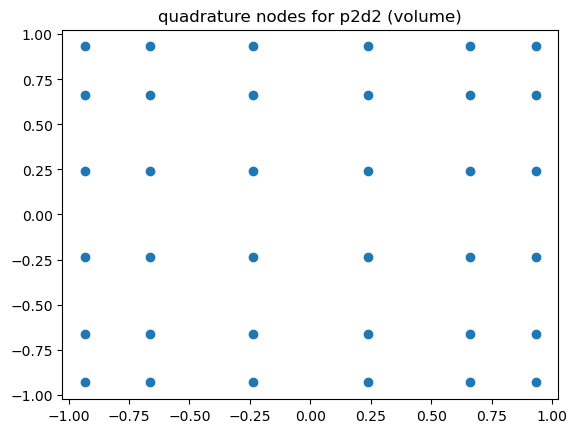

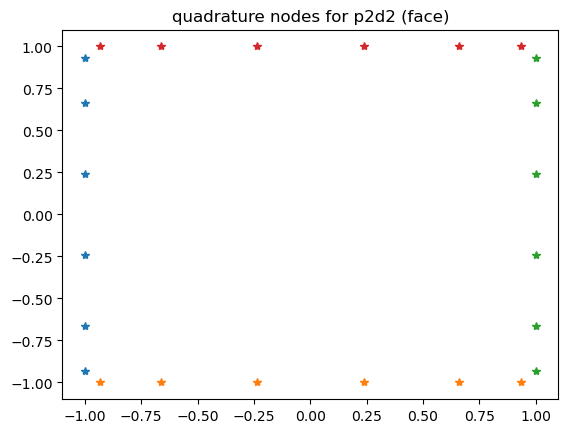

In [6]:
'''
# Define pameterized problem, in this case, the governing equation is changing and the loss
# function is changing
'''
S=[5] # Parametrize the source value in the pde -F_ij,j=S_i
LossF=[]
for i in S: 
	f=lambda x,el: i
	prob=setup_prob_eqn_handcode.setup_linelptc_sclr_base_handcode(2,K,f,Qb,bnd2nbc) # Set up the problem
	femsp=create_femsp_cg(prob,msh,porder,e2vcg,porder,e2vcg,dbc)
	fcn=lambda u_,u_n_1:create_fem_resjac('cg',u_n_1,u_,msh.transfdatacontiguous,
									femsp.elem,femsp.elem_data, 
                   				    femsp.ldof2gdof_eqn.ldof2gdof,
                  			        femsp.ldof2gdof_var.ldof2gdof,
									msh.e2e,femsp.spmat,dbc,[i for i in range(ndof) if i not in dbc_idx],parsfuncI,None)
	LossF.append(fcn)


#体积分点、面积分点绘制
plt.plot(femsp.lfcnsp_eqn.zqv[0,:], femsp.lfcnsp_eqn.zqv[1,:], 'o')
plt.title('quadrature nodes for p2d2 (volume)')

plt.figure()
plt.plot(femsp.lfcnsp_eqn.zqf[0,:,0], femsp.lfcnsp_eqn.zqf[1,:, 0], '*')
plt.plot(femsp.lfcnsp_eqn.zqf[0,:,1], femsp.lfcnsp_eqn.zqf[1,:, 1], '*')
plt.plot(femsp.lfcnsp_eqn.zqf[0,:,2], femsp.lfcnsp_eqn.zqf[1,:, 2], '*')
plt.plot(femsp.lfcnsp_eqn.zqf[0,:,3], femsp.lfcnsp_eqn.zqf[1,:, 3], '*')
plt.title('quadrature nodes for p2d2 (face)')
    
#看一下
[neqn_per_elem,neqn,ndimP1,nq]=femsp.elem.Tv_eqn_ref.shape
#打印这些信息看一下，标注名字
print('neqn_per_elem:',neqn_per_elem)
print('neqn:',neqn)
print('ndimP1:',ndimP1)
print('nq:',nq)
[nvar_per_elem,nvar,_,_]=femsp.elem.Tv_var_ref.shape
print('nvar_per_elem:',nvar_per_elem)
print('nvar:',nvar)
#打印transffata的信息
#print(msh.transfdatacontiguous.detG)
#打印积分权重
print(femsp.elem.wq)
print(femsp.elem.wqf)


[neqn_per_elem,neqn,ndimP1,nqf,nf]=femsp.elem.Tvf_eqn_ref.shape
print('neqn_per_elem:',neqn_per_elem)
print('neqn:',neqn)
print('ndimP1:',ndimP1)
print('nqf:',nqf)
print('nf:',nf)

print(femsp.elem_data.nbcnbr)
#输出一下ldof2gdof
print('ldof2gdof:',femsp.ldof2gdof_eqn.ldof2gdof)


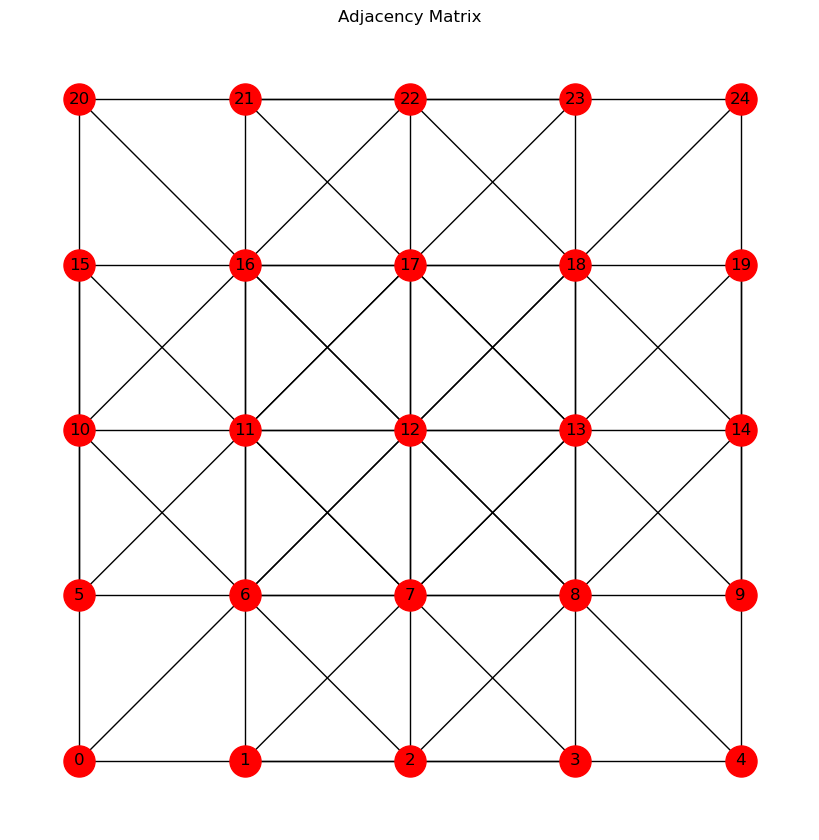

In [20]:
#绘制节点和邻接矩阵的示意图（connectivity是邻接矩阵）
edges = connectivity.cpu().numpy().T.tolist()
G = nx.Graph()
G.add_edges_from(edges)

pos = {i: (xcg[0, i], xcg[1, i]) for i in range(xcg.shape[1])}
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='r', node_size=500, font_size=12)
plt.title('Adjacency Matrix')
plt.show()

In [21]:
def create_dataloader(xcg, solution,t):
	Graph=[]
	Ue=Double(analyticalPossion(xcg,t).flatten().reshape(ndof,1))
	fcn_id=Double(np.asarray([0]))
	Ue_aug=torch.cat((fcn_id,Ue),axis=0)
	Uin=Double(xcg.T)
	#给Uin加上一列,就是把上一次得到的solution加上去
	Un_1=Double(solution)
	#Un_1 =torch.zeros_like(Un_1)
	#整理形状
	Uin=torch.cat((Uin,Un_1),axis=1)
	#for i in range(Uin.shape[0]):
	#这里改变一下输入的数据
	graph=Data(x=Un_1,y=Ue_aug,edge_index=connectivity)
	Graph.append(graph)

	DataList=[[Graph[i]] for i in range(len(S))]
	TrainDataloader=DataLoader(DataList,batch_size=1)
	return TrainDataloader, Graph, Un_1



In [36]:
#加载模型
statr_dict=torch.load('C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/model_heat_130.pth')
model.load_state_dict(statr_dict)


<All keys matched successfully>

In [38]:
#循环推导：设定初值，然后用模型推理，再用推理结果作为下一次的输入
#这里的初值是解析解
Un_rst_list = []
t = 0
solution = analyticalPossion(xcg,t)
Un_rst_list.append(solution)

for i in range(50):
    #训练模型
    # Training Data
    #构造这次训练的dataloader、graph和Un_1
    t = (i+1)*delta_t
    solution = solution.reshape(ndof, 1)
    TrainDataloader, Graph, Un_1 = create_dataloader(xcg, solution, t)

    #带入模型推理
    solution = model(Graph[0].to('cuda'))

    dbc_val=analyticalPossion(xcg,t).flatten().reshape(ndof,1)[dbc_idx]
    dbc=create_dbc_strct(xcg.shape[1]*nvar,dbc_idx,dbc_val) # Create the class of boundary condition
    solution[dbc.dbc_idx]=Double(dbc.dbc_val.reshape([len(dbc.dbc_val),1]))

    solution=solution.detach().cpu().numpy()
    #边界赋值

   
    Un_rst_list.append(solution)
   

l2_error: 0.008223510769351704
l1_error: 0.024128773570087067
l_inf_error: 0.0037229174909672313
zeval: [[-1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5
   1.  -1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5  1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5 -0.5 -0.5 -0.5 -0.5  0.   0.   0.   0.
   0.   0.5  0.5  0.5  0.5  0.5  1.   1.   1.   1.   1. ]]
评估点的数量  25
zeval: [[-1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5
   1.  -1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5  1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5 -0.5 -0.5 -0.5 -0.5  0.   0.   0.   0.
   0.   0.5  0.5  0.5  0.5  0.5  1.   1.   1.   1.   1. ]]
评估点的数量  25


C:\Users\puppyCookie\AppData\Local\Temp\ipykernel_17748\3124410872.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()              # 自动调整子图间距
C:\Users\puppyCookie\AppData\Local\Temp\ipykernel_17748\3124410872.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()              # 自动调整子图间距


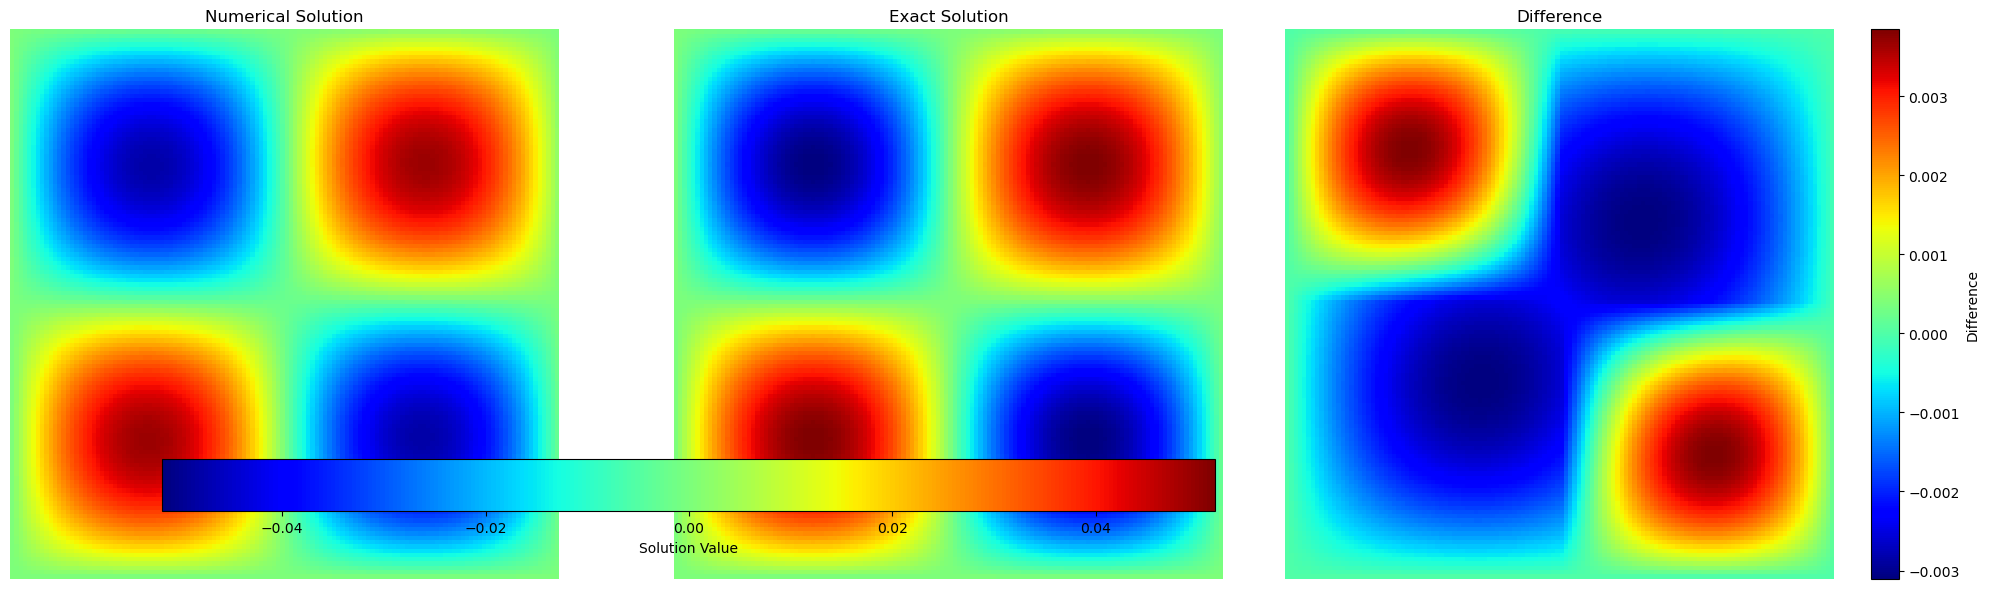

In [41]:

solution=Un_rst_list[30]
Ufem=analyticalPossion(xcg,0.3).flatten().reshape(ndof,1)
#检查真解和数值解的形状是否一致，如果不一致就统一成solution的形状
#计算误差
l2_error=np.sqrt(np.sum((solution-Ufem)**2))
l1_error=np.sum(np.abs(solution-Ufem))
l_inf_error=np.max(np.abs(solution-Ufem))
print('l2_error:', l2_error)
print('l1_error:', l1_error)
print('l_inf_error:', l_inf_error)
if Ufem.shape!=solution.shape:
    Ufem=Ufem.reshape(solution.shape)
fig, axes, cbar = visualize_fem(
    msh, 
    udg=solution[e2vcg], 
    ufem=Ufem[e2vcg],        # 传入真解
    opts={"plot_elem": True, "nref": 6}, 
    which_bnd=[]
)

# 分别设置三个子图的标题
titles = ['Numerical Solution', 'Exact Solution', 'Difference']
for ax, title in zip(axes, titles):
    ax.tick_params(axis='both', which='both', 
                   bottom=False, left=False, 
                   top=False, labelbottom=False, labelleft=False)
    ax.set_title(title)
    ax.axis('off')

plt.margins(0,0)
plt.tight_layout()              # 自动调整子图间距
plt.show()